In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
cp -rf "/kaggle/input/drone-vs-bird" "/kaggle/working"

In [3]:
mkdir "/kaggle/working/Results"

In [4]:
import yaml

config_data = {
    'dataset_dir': "/kaggle/working/drone-vs-bird/dataset",
    'encodings_dir': "/kaggle/working/encodings",
    'project_directory': "/kaggle/working/",
    'results_path': "/kaggle/working/Results",
    'batch_size': 32,
    'local_model_dir': "pretrained_models",
    'available_models': [
        "alexnet",
        "resnet18",
        "resnet101",
        "resnet152",
        "resnext50_32x4d",
        "resnext101_32x8d",
        "wide_resnet50_2",
        "wide_resnet101_2",
        "vgg11",
        "vgg19",
        "convnext_tiny",
        "convnext_small",
        "convnext_base",
        "convnext_large",
        "efficientnet_b5",
        "efficientnet_b6",
        "efficientnet_b7",
        "efficientnet_v2_s",
        "efficientnet_v2_m",
        "efficientnet_v2_l",
        "inception_v3",
        "googlenet",
        "mnasnet0_5",
        "mnasnet0_75",
        "mnasnet1_0",
        "mnasnet1_3",
        "mobilenet_v2",
        "mobilenet_v3_large",
        "mobilenet_v3_small",
        "densenet169",
        "densenet201",
        "shufflenet_v2_x1_5",
        "shufflenet_v2_x2_0",
        "regnet_y_800mf",
        "regnet_y_3_2gf",
        "regnet_y_16gf",
        "regnet_y_32gf",
        "regnet_x_800mf",
        "regnet_x_3_2gf",
        "regnet_x_32gf"
    ],
    'excluded_models': [
        "squeezenet1_0",
        "squeezenet1_1"
    ],
    'svm_kernel': "linear",
    'n_splits': 5
}

# Write the dictionary to config.yaml file
with open('config.yaml', 'w') as yaml_file:
    yaml.dump(config_data, yaml_file, default_flow_style=False, sort_keys=False)

print("config.yaml file created successfully!")

config.yaml file created successfully!


In [5]:
import os
import yaml
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import sys
import glob

# Load configuration from a YAML file
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Define the main function for encoding images
def encode_images(config_path):
    # Load configuration
    config = load_config(config_path)
    dataset_dir = config['dataset_dir']
    encodings_dir = config['encodings_dir']
    batch_size = config.get('batch_size', 32)
    excluded_models = config.get('excluded_models', [])
    local_model_dir = config.get('local_model_dir', "pretrained_models")
    available_models = config['available_models']

    # Set the device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Expanded list of pre-trained models to 70 models (Now read from config)
    model_names = available_models

    # Exclude specified models (Now read from config)
    excluded_models = excluded_models
    model_names = [model for model in model_names if model not in excluded_models]

    # Define the local directory for storing models and temporary files (Now read from config)
    local_model_dir = local_model_dir
    os.makedirs(local_model_dir, exist_ok=True)
    torch.hub.set_dir(local_model_dir)  # Set PyTorch to use the specified local directory for model storage

    # Define a transform to resize images and convert them to tensors (Keep this as it's not config dependent)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create the 'encodings' directory if it does not exist (Now read from config)
    os.makedirs(encodings_dir, exist_ok=True)

    # Custom loader function to handle loading errors (Keep this as it's not config dependent)
    def pil_loader_with_error_handling(path: str):
        try:
            with open(path, "rb") as f:
                img = Image.open(f)
                return img.convert("RGB")
        except UnidentifiedImageError:
            print(f"Skipping file {path}: cannot identify image file.")
            return None

    # Load the dataset using ImageFolder with the custom loader (Now read from config)
    dataset = ImageFolder(root=dataset_dir, transform=transform, loader=pil_loader_with_error_handling)

    # Filter out invalid images (Keep this as it's not config dependent)
    valid_indices = [i for i, (img, _) in enumerate(dataset.imgs) if dataset.loader(dataset.imgs[i][0]) is not None]
    valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
    dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # Use batch_size from config

    # Display the number of images to be encoded (Keep this as it's not config dependent)
    num_images = len(valid_dataset)
    print(f"Number of images to be encoded: {num_images}")

    # Loop through each model and encode images
    latest_model = sorted(model_names, key=lambda model: os.path.getctime(os.path.join(encodings_dir, model)) if os.path.exists(os.path.join(encodings_dir, model)) else 0, reverse=True)[0]
    for model_name in model_names:
        if model_name == latest_model:
            print(f"Resuming with most recently incomplete model: {model_name}")
        else:
            print(f"Processing with model: {model_name}")

        model_encodings_dir = os.path.join(encodings_dir, model_name) # Now read from config
        os.makedirs(model_encodings_dir, exist_ok=True)

        # Check if the encodings for this model already exist or if there are incomplete encodings (Keep this logic)
        if encodings_exist(model_encodings_dir) and not os.path.exists(os.path.join(model_encodings_dir, 'features_temp.npy')):
            print(f"Encodings for model {model_name} already exist and are complete. Skipping to next model.")
            continue

        # Load or download model (Now read from config - local_model_dir)
        model = load_or_download_model(model_name, local_model_dir, device)

        # Modify the model to use only the feature extractor part (Keep this logic)
        model = modify_model_for_feature_extraction(model, model_name)

        # Set the model to evaluation mode (Keep this logic)
        model.eval()

        all_features = []
        all_labels = []

        # Try to load saved batches if any exist (Keep this logic - model_encodings_dir)
        loaded_features, loaded_labels, last_batch_index = load_saved_batches(model_encodings_dir)
        # Initialize last_batch_index to 0 if no saved batches are available (Keep this logic)
        if last_batch_index is None:
            last_batch_index = 0

        # If there are saved batches, resume from where it left off (Keep this logic)
        if loaded_features is not None and loaded_labels is not None:
            all_features = list(loaded_features)
            all_labels = list(loaded_labels)
            print(f"Resuming from saved batch for model: {model_name}")

        for batch_index, (images, labels) in enumerate(tqdm(dataloader)):
            # Skip batches that have already been processed (Keep this logic)
            if batch_index < last_batch_index:
                continue

            images = images.to(device)

            with torch.no_grad():
                output = model(images)
                output = process_output(output, model_name)

            features = output.cpu().numpy()
            all_features.append(features)
            all_labels.extend(labels.numpy())

            # Save temporary batches after each iteration (Keep this logic - model_encodings_dir)
            last_batch_index = batch_index + 1
            save_temp_batches(model_encodings_dir, np.array(all_features, dtype=object), np.array(all_labels, dtype=object), last_batch_index)

        all_features = np.concatenate(all_features, axis=0)
        all_labels = np.array(all_labels)

        # Display the dimensions of all_features and all_labels (Keep this as it's not config dependent)
        print(f"Dimensions of all_features: {all_features.shape}")
        print(f"Dimensions of all_labels: {all_labels.shape}")

        # Save the encoded images and labels as .npy files (Keep this logic - model_encodings_dir)
        np.save(os.path.join(model_encodings_dir, 'encoded_images.npy'), all_features)
        np.save(os.path.join(model_encodings_dir, 'labels.npy'), all_labels)

        # Delete temporary batches after completion if encoding is successful (Keep this logic - model_encodings_dir)
        delete_temp_batches(model_encodings_dir)
        # Remove last batch index file if encoding is successful (Keep this logic - model_encodings_dir)
        last_batch_index_path = os.path.join(model_encodings_dir, 'last_batch_index.npy')
        if os.path.exists(last_batch_index_path):
            os.remove(last_batch_index_path)

        print(f"Encoding and saving complete for model: {model_name}")

        # **NEW: Remove the model from memory**
        del model
        torch.cuda.empty_cache() # Optional: Explicitly clear CUDA cache if using GPU

        # **NEW: Remove model weights from local disk**
        remove_model_weights_from_disk(model_name, local_model_dir)

    print("All models processed!")

# Helper functions for loading, processing, and saving data (No changes needed here as paths are passed as arguments)
def load_or_download_model(model_name, local_model_dir, device):
    """
    Load a pre-trained model from the local directory if available; otherwise, download it.
    If a corrupt model is detected, delete it and download it again.
    """
    checkpoints_dir = os.path.join(local_model_dir, 'checkpoints')
    os.makedirs(checkpoints_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoints_dir, f"{model_name}.pth")

    # Attempt to find existing model checkpoint by pattern matching
    existing_checkpoints = glob.glob(os.path.join(checkpoints_dir, f"{model_name}*.pth"))

    try:
        if existing_checkpoints:
            print(f"Found existing model weights for {model_name}. Loading from local directory.")
            model = getattr(models, model_name)(weights=None)
            model.load_state_dict(torch.load(existing_checkpoints[0]))
        else:
            print(f"Model weights for {model_name} not found. Downloading...")
            model = getattr(models, model_name)(weights='DEFAULT')
            torch.save(model.state_dict(), checkpoint_path)
    except (RuntimeError, ValueError, OSError) as e:
        print(f"Error loading model weights for {model_name}: {e}. Deleting and re-downloading...")
        # Delete potentially corrupt model checkpoint
        for checkpoint in existing_checkpoints:
            try:
                os.remove(checkpoint)
            except OSError:
                print(f"Failed to delete corrupt checkpoint: {checkpoint}")
        # Redownload the model
        model = getattr(models, model_name)(weights='DEFAULT')
        torch.save(model.state_dict(), checkpoint_path)

    return model.to(device)


def modify_model_for_feature_extraction(model, model_name):
    # Modify the model to use only the feature extractor part
    if 'resnet' in model_name or 'resnext' in model_name or 'wide_resnet' in model_name:
        model = torch.nn.Sequential(*list(model.children())[:-2])
    elif 'mobilenet' in model_name or 'mnasnet' in model_name:
        model.classifier = torch.nn.Identity()
    elif 'vgg' in model_name or 'alexnet' in model_name:
        model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
    elif 'squeezenet' in model_name:
        model.classifier = torch.nn.Identity()
    elif 'googlenet' in model_name or 'inception' in model_name:
        model.fc = torch.nn.Identity()
    elif 'efficientnet' in model_name or 'convnext' in model_name:
        model.classifier = torch.nn.Identity()
    elif 'shufflenet' in model_name or 'regnet' in model_name:
        model.fc = torch.nn.Identity()  # Removing the classifier head for feature extraction
    elif 'densenet' in model_name:
        model.classifier = torch.nn.Identity()
    else:
        raise ValueError(f"Model {model_name} is not supported for feature extraction.")
    return model

def model_weights_exist(model_name, local_model_dir):
    checkpoints_dir = os.path.join(local_model_dir, 'checkpoints')
    return len(glob.glob(os.path.join(checkpoints_dir, f"{model_name}*.pth"))) > 0

def encodings_exist(model_encodings_dir):
    features_path = os.path.join(model_encodings_dir, 'encoded_images.npy')
    labels_path = os.path.join(model_encodings_dir, 'labels.npy')
    return os.path.exists(features_path) and os.path.exists(labels_path)

def load_saved_batches(model_encodings_dir):
    temp_features_path = os.path.join(model_encodings_dir, 'features_temp.npy')
    temp_labels_path = os.path.join(model_encodings_dir, 'labels_temp.npy')
    last_batch_index_path = os.path.join(model_encodings_dir, 'last_batch_index.npy')
    if os.path.exists(temp_features_path) and os.path.exists(temp_labels_path) and os.path.exists(last_batch_index_path):
        try:
            features = np.load(temp_features_path, allow_pickle=True)
            labels = np.load(temp_labels_path, allow_pickle=True)
            last_batch_index = np.load(last_batch_index_path, allow_pickle=True)
            return features, labels, last_batch_index
        except (EOFError, ValueError):
            print(f"Error loading temporary batches for {model_encodings_dir}. Deleting corrupted files and restarting from last known good state.")
            # Delete corrupted files to allow fresh restart
            if os.path.exists(temp_features_path):
                os.remove(temp_features_path)
            if os.path.exists(temp_labels_path):
                os.remove(temp_labels_path)
            if os.path.exists(last_batch_index_path):
                os.remove(last_batch_index_path)
    return None, None, None

def save_temp_batches(model_encodings_dir, features, labels, last_batch_index):
    temp_features_path = os.path.join(model_encodings_dir, 'features_temp.npy')
    temp_labels_path = os.path.join(model_encodings_dir, 'labels_temp.npy')
    last_batch_index_path = os.path.join(model_encodings_dir, 'last_batch_index.npy')
    np.save(temp_features_path, features, allow_pickle=True)
    np.save(temp_labels_path, labels, allow_pickle=True)
    np.save(last_batch_index_path, last_batch_index, allow_pickle=True)

def delete_temp_batches(model_encodings_dir):
    temp_features_path = os.path.join(model_encodings_dir, 'features_temp.npy')
    temp_labels_path = os.path.join(model_encodings_dir, 'labels_temp.npy')
    last_batch_index_path = os.path.join(model_encodings_dir, 'last_batch_index.npy')
    if os.path.exists(temp_features_path):
        os.remove(temp_features_path)
    if os.path.exists(temp_labels_path):
        os.remove(temp_labels_path)
    if os.path.exists(last_batch_index_path):
        os.remove(last_batch_index_path)

def process_output(output, model_name):
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    if len(output.size()) == 4:
        output = global_avg_pool(output)
        output = output.view(output.size(0), -1)
    elif len(output.size()) != 2:
        raise ValueError(f"Unexpected output size from model {model_name}: {output.size()}")
    return output

# **NEW Function:** Remove model weights from disk
def remove_model_weights_from_disk(model_name, local_model_dir):
    checkpoints_dir = os.path.join(local_model_dir, 'checkpoints')
    model_weights_pattern = os.path.join(checkpoints_dir, f"{model_name}*.pth")
    files_to_remove = glob.glob(model_weights_pattern)
    for file_path in files_to_remove:
        try:
            os.remove(file_path)
            print(f"Removed model weights file: {file_path}")
        except OSError as e:
            print(f"Error removing model weights file {file_path}: {e}")

# Command-line interface
if __name__ == "__main__":
    config_path = '/kaggle/working/config.yaml'  # Set config path here
    encode_images(config_path)

Number of images to be encoded: 4106
Resuming with most recently incomplete model: alexnet
Model weights for alexnet not found. Downloading...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to pretrained_models/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 240MB/s] 
100%|██████████| 129/129 [03:35<00:00,  1.67s/it]


Dimensions of all_features: (4106, 4096)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: alexnet
Removed model weights file: pretrained_models/checkpoints/alexnet-owt-7be5be79.pth
Removed model weights file: pretrained_models/checkpoints/alexnet.pth
Processing with model: resnet18
Model weights for resnet18 not found. Downloading...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to pretrained_models/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]
100%|██████████| 129/129 [01:34<00:00,  1.37it/s]


Dimensions of all_features: (4106, 512)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: resnet18
Removed model weights file: pretrained_models/checkpoints/resnet18-f37072fd.pth
Removed model weights file: pretrained_models/checkpoints/resnet18.pth
Processing with model: resnet101
Model weights for resnet101 not found. Downloading...


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to pretrained_models/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 229MB/s] 
100%|██████████| 129/129 [02:26<00:00,  1.14s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: resnet101
Removed model weights file: pretrained_models/checkpoints/resnet101-cd907fc2.pth
Removed model weights file: pretrained_models/checkpoints/resnet101.pth
Processing with model: resnet152
Model weights for resnet152 not found. Downloading...


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to pretrained_models/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 220MB/s] 
100%|██████████| 129/129 [02:34<00:00,  1.20s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: resnet152
Removed model weights file: pretrained_models/checkpoints/resnet152-f82ba261.pth
Removed model weights file: pretrained_models/checkpoints/resnet152.pth
Processing with model: resnext50_32x4d
Model weights for resnext50_32x4d not found. Downloading...


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to pretrained_models/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 186MB/s]
100%|██████████| 129/129 [02:29<00:00,  1.16s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: resnext50_32x4d
Removed model weights file: pretrained_models/checkpoints/resnext50_32x4d-1a0047aa.pth
Removed model weights file: pretrained_models/checkpoints/resnext50_32x4d.pth
Processing with model: resnext101_32x8d
Model weights for resnext101_32x8d not found. Downloading...


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth" to pretrained_models/checkpoints/resnext101_32x8d-110c445d.pth
100%|██████████| 340M/340M [00:01<00:00, 212MB/s] 
100%|██████████| 129/129 [02:50<00:00,  1.33s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: resnext101_32x8d
Removed model weights file: pretrained_models/checkpoints/resnext101_32x8d-110c445d.pth
Removed model weights file: pretrained_models/checkpoints/resnext101_32x8d.pth
Processing with model: wide_resnet50_2
Model weights for wide_resnet50_2 not found. Downloading...


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to pretrained_models/checkpoints/wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:01<00:00, 232MB/s] 
100%|██████████| 129/129 [02:35<00:00,  1.21s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: wide_resnet50_2
Removed model weights file: pretrained_models/checkpoints/wide_resnet50_2.pth
Removed model weights file: pretrained_models/checkpoints/wide_resnet50_2-9ba9bcbe.pth
Processing with model: wide_resnet101_2
Model weights for wide_resnet101_2 not found. Downloading...


Downloading: "https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth" to pretrained_models/checkpoints/wide_resnet101_2-d733dc28.pth
100%|██████████| 485M/485M [00:20<00:00, 24.8MB/s] 
100%|██████████| 129/129 [02:43<00:00,  1.27s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: wide_resnet101_2
Removed model weights file: pretrained_models/checkpoints/wide_resnet101_2-d733dc28.pth
Removed model weights file: pretrained_models/checkpoints/wide_resnet101_2.pth
Processing with model: vgg11
Model weights for vgg11 not found. Downloading...


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to pretrained_models/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 230MB/s] 
100%|██████████| 129/129 [03:32<00:00,  1.65s/it]


Dimensions of all_features: (4106, 4096)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: vgg11
Removed model weights file: pretrained_models/checkpoints/vgg11.pth
Removed model weights file: pretrained_models/checkpoints/vgg11-8a719046.pth
Processing with model: vgg19
Model weights for vgg19 not found. Downloading...


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to pretrained_models/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 233MB/s] 
100%|██████████| 129/129 [03:36<00:00,  1.68s/it]


Dimensions of all_features: (4106, 4096)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: vgg19
Removed model weights file: pretrained_models/checkpoints/vgg19-dcbb9e9d.pth
Removed model weights file: pretrained_models/checkpoints/vgg19.pth
Processing with model: convnext_tiny
Model weights for convnext_tiny not found. Downloading...


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to pretrained_models/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 219MB/s] 
100%|██████████| 129/129 [01:46<00:00,  1.21it/s]


Dimensions of all_features: (4106, 768)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: convnext_tiny
Removed model weights file: pretrained_models/checkpoints/convnext_tiny-983f1562.pth
Removed model weights file: pretrained_models/checkpoints/convnext_tiny.pth
Processing with model: convnext_small
Model weights for convnext_small not found. Downloading...


Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to pretrained_models/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 205MB/s] 
100%|██████████| 129/129 [01:54<00:00,  1.13it/s]


Dimensions of all_features: (4106, 768)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: convnext_small
Removed model weights file: pretrained_models/checkpoints/convnext_small.pth
Removed model weights file: pretrained_models/checkpoints/convnext_small-0c510722.pth
Processing with model: convnext_base
Model weights for convnext_base not found. Downloading...


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to pretrained_models/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 215MB/s] 
100%|██████████| 129/129 [02:11<00:00,  1.02s/it]


Dimensions of all_features: (4106, 1024)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: convnext_base
Removed model weights file: pretrained_models/checkpoints/convnext_base-6075fbad.pth
Removed model weights file: pretrained_models/checkpoints/convnext_base.pth
Processing with model: convnext_large
Model weights for convnext_large not found. Downloading...


Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to pretrained_models/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:18<00:00, 41.8MB/s] 
100%|██████████| 129/129 [02:49<00:00,  1.31s/it]


Dimensions of all_features: (4106, 1536)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: convnext_large
Removed model weights file: pretrained_models/checkpoints/convnext_large-ea097f82.pth
Removed model weights file: pretrained_models/checkpoints/convnext_large.pth
Processing with model: efficientnet_b5
Model weights for efficientnet_b5 not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to pretrained_models/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 206MB/s] 
100%|██████████| 129/129 [02:22<00:00,  1.10s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_b5
Removed model weights file: pretrained_models/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_b5.pth
Processing with model: efficientnet_b6
Model weights for efficientnet_b6 not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to pretrained_models/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:00<00:00, 222MB/s] 
100%|██████████| 129/129 [02:35<00:00,  1.20s/it]


Dimensions of all_features: (4106, 2304)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_b6
Removed model weights file: pretrained_models/checkpoints/efficientnet_b6.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
Processing with model: efficientnet_b7
Model weights for efficientnet_b7 not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to pretrained_models/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 215MB/s] 
100%|██████████| 129/129 [02:46<00:00,  1.29s/it]


Dimensions of all_features: (4106, 2560)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_b7
Removed model weights file: pretrained_models/checkpoints/efficientnet_b7.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
Processing with model: efficientnet_v2_s
Model weights for efficientnet_v2_s not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to pretrained_models/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 151MB/s] 
100%|██████████| 129/129 [01:54<00:00,  1.12it/s]


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_v2_s
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_s-dd5fe13b.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_s.pth
Processing with model: efficientnet_v2_m
Model weights for efficientnet_v2_m not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to pretrained_models/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 213MB/s] 
100%|██████████| 129/129 [02:01<00:00,  1.06it/s]


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_v2_m
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_m-dc08266a.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_m.pth
Processing with model: efficientnet_v2_l
Model weights for efficientnet_v2_l not found. Downloading...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to pretrained_models/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 214MB/s] 
100%|██████████| 129/129 [02:12<00:00,  1.03s/it]


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: efficientnet_v2_l
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_l.pth
Removed model weights file: pretrained_models/checkpoints/efficientnet_v2_l-59c71312.pth
Processing with model: inception_v3
Model weights for inception_v3 not found. Downloading...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to pretrained_models/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 215MB/s] 
100%|██████████| 129/129 [02:13<00:00,  1.03s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: inception_v3
Removed model weights file: pretrained_models/checkpoints/inception_v3.pth
Removed model weights file: pretrained_models/checkpoints/inception_v3_google-0cc3c7bd.pth
Processing with model: googlenet
Model weights for googlenet not found. Downloading...


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to pretrained_models/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 142MB/s] 
100%|██████████| 129/129 [01:43<00:00,  1.24it/s]
Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to pretrained_models/checkpoints/mnasnet0.5_top1_67.823-3ffadce67e.pth


Dimensions of all_features: (4106, 1024)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: googlenet
Removed model weights file: pretrained_models/checkpoints/googlenet.pth
Removed model weights file: pretrained_models/checkpoints/googlenet-1378be20.pth
Processing with model: mnasnet0_5
Model weights for mnasnet0_5 not found. Downloading...


100%|██████████| 8.59M/8.59M [00:00<00:00, 94.5MB/s]
100%|██████████| 129/129 [01:48<00:00,  1.19it/s]
Downloading: "https://download.pytorch.org/models/mnasnet0_75-7090bc5f.pth" to pretrained_models/checkpoints/mnasnet0_75-7090bc5f.pth


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mnasnet0_5
Removed model weights file: pretrained_models/checkpoints/mnasnet0_5.pth
Processing with model: mnasnet0_75
Model weights for mnasnet0_75 not found. Downloading...


100%|██████████| 12.3M/12.3M [00:00<00:00, 177MB/s]
100%|██████████| 129/129 [01:50<00:00,  1.16it/s]
Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to pretrained_models/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mnasnet0_75
Removed model weights file: pretrained_models/checkpoints/mnasnet0_75.pth
Removed model weights file: pretrained_models/checkpoints/mnasnet0_75-7090bc5f.pth
Processing with model: mnasnet1_0
Model weights for mnasnet1_0 not found. Downloading...


100%|██████████| 16.9M/16.9M [00:00<00:00, 182MB/s]
100%|██████████| 129/129 [01:50<00:00,  1.17it/s]
Downloading: "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth" to pretrained_models/checkpoints/mnasnet1_3-a4c69d6f.pth


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mnasnet1_0
Removed model weights file: pretrained_models/checkpoints/mnasnet1_0.pth
Processing with model: mnasnet1_3
Model weights for mnasnet1_3 not found. Downloading...


100%|██████████| 24.2M/24.2M [00:00<00:00, 117MB/s] 
100%|██████████| 129/129 [01:50<00:00,  1.17it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to pretrained_models/checkpoints/mobilenet_v2-7ebf99e0.pth


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mnasnet1_3
Removed model weights file: pretrained_models/checkpoints/mnasnet1_3.pth
Removed model weights file: pretrained_models/checkpoints/mnasnet1_3-a4c69d6f.pth
Processing with model: mobilenet_v2
Model weights for mobilenet_v2 not found. Downloading...


100%|██████████| 13.6M/13.6M [00:00<00:00, 92.8MB/s]
100%|██████████| 129/129 [01:48<00:00,  1.19it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to pretrained_models/checkpoints/mobilenet_v3_large-5c1a4163.pth


Dimensions of all_features: (4106, 1280)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mobilenet_v2
Removed model weights file: pretrained_models/checkpoints/mobilenet_v2.pth
Removed model weights file: pretrained_models/checkpoints/mobilenet_v2-7ebf99e0.pth
Processing with model: mobilenet_v3_large
Model weights for mobilenet_v3_large not found. Downloading...


100%|██████████| 21.1M/21.1M [00:00<00:00, 181MB/s]
100%|██████████| 129/129 [01:41<00:00,  1.28it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to pretrained_models/checkpoints/mobilenet_v3_small-047dcff4.pth


Dimensions of all_features: (4106, 960)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mobilenet_v3_large
Removed model weights file: pretrained_models/checkpoints/mobilenet_v3_large-5c1a4163.pth
Removed model weights file: pretrained_models/checkpoints/mobilenet_v3_large.pth
Processing with model: mobilenet_v3_small
Model weights for mobilenet_v3_small not found. Downloading...


100%|██████████| 9.83M/9.83M [00:00<00:00, 143MB/s]
100%|██████████| 129/129 [01:32<00:00,  1.40it/s]


Dimensions of all_features: (4106, 576)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: mobilenet_v3_small
Removed model weights file: pretrained_models/checkpoints/mobilenet_v3_small.pth
Removed model weights file: pretrained_models/checkpoints/mobilenet_v3_small-047dcff4.pth
Processing with model: densenet169
Model weights for densenet169 not found. Downloading...


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to pretrained_models/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 214MB/s]
100%|██████████| 129/129 [02:06<00:00,  1.02it/s]


Dimensions of all_features: (4106, 1664)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: densenet169
Removed model weights file: pretrained_models/checkpoints/densenet169-b2777c0a.pth
Removed model weights file: pretrained_models/checkpoints/densenet169.pth
Processing with model: densenet201
Model weights for densenet201 not found. Downloading...


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to pretrained_models/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 230MB/s]
100%|██████████| 129/129 [02:16<00:00,  1.06s/it]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1_5-3c479a10.pth" to pretrained_models/checkpoints/shufflenetv2_x1_5-3c479a10.pth


Dimensions of all_features: (4106, 1920)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: densenet201
Removed model weights file: pretrained_models/checkpoints/densenet201.pth
Removed model weights file: pretrained_models/checkpoints/densenet201-c1103571.pth
Processing with model: shufflenet_v2_x1_5
Model weights for shufflenet_v2_x1_5 not found. Downloading...


100%|██████████| 13.6M/13.6M [00:00<00:00, 137MB/s]
100%|██████████| 129/129 [01:42<00:00,  1.25it/s]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to pretrained_models/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth


Dimensions of all_features: (4106, 1024)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: shufflenet_v2_x1_5
Removed model weights file: pretrained_models/checkpoints/shufflenet_v2_x1_5.pth
Processing with model: shufflenet_v2_x2_0
Model weights for shufflenet_v2_x2_0 not found. Downloading...


100%|██████████| 28.4M/28.4M [00:00<00:00, 202MB/s]
100%|██████████| 129/129 [02:09<00:00,  1.01s/it]


Dimensions of all_features: (4106, 2048)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: shufflenet_v2_x2_0
Removed model weights file: pretrained_models/checkpoints/shufflenet_v2_x2_0.pth
Processing with model: regnet_y_800mf
Model weights for regnet_y_800mf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to pretrained_models/checkpoints/regnet_y_800mf-58fc7688.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 150MB/s]
100%|██████████| 129/129 [01:38<00:00,  1.30it/s]


Dimensions of all_features: (4106, 784)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_y_800mf
Removed model weights file: pretrained_models/checkpoints/regnet_y_800mf-58fc7688.pth
Removed model weights file: pretrained_models/checkpoints/regnet_y_800mf.pth
Processing with model: regnet_y_3_2gf
Model weights for regnet_y_3_2gf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_y_3_2gf-9180c971.pth" to pretrained_models/checkpoints/regnet_y_3_2gf-9180c971.pth
100%|██████████| 74.6M/74.6M [00:00<00:00, 229MB/s]
100%|██████████| 129/129 [02:02<00:00,  1.05it/s]


Dimensions of all_features: (4106, 1512)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_y_3_2gf
Removed model weights file: pretrained_models/checkpoints/regnet_y_3_2gf-9180c971.pth
Removed model weights file: pretrained_models/checkpoints/regnet_y_3_2gf.pth
Processing with model: regnet_y_16gf
Model weights for regnet_y_16gf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_y_16gf-3e4a00f9.pth" to pretrained_models/checkpoints/regnet_y_16gf-3e4a00f9.pth
100%|██████████| 319M/319M [00:01<00:00, 212MB/s] 
100%|██████████| 129/129 [03:08<00:00,  1.46s/it]


Dimensions of all_features: (4106, 3024)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_y_16gf
Removed model weights file: pretrained_models/checkpoints/regnet_y_16gf-3e4a00f9.pth
Removed model weights file: pretrained_models/checkpoints/regnet_y_16gf.pth
Processing with model: regnet_y_32gf
Model weights for regnet_y_32gf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_y_32gf-8db6d4b5.pth" to pretrained_models/checkpoints/regnet_y_32gf-8db6d4b5.pth
100%|██████████| 554M/554M [00:02<00:00, 223MB/s] 
100%|██████████| 129/129 [03:30<00:00,  1.63s/it]


Dimensions of all_features: (4106, 3712)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_y_32gf
Removed model weights file: pretrained_models/checkpoints/regnet_y_32gf.pth
Removed model weights file: pretrained_models/checkpoints/regnet_y_32gf-8db6d4b5.pth
Processing with model: regnet_x_800mf
Model weights for regnet_x_800mf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_x_800mf-94a99ebd.pth" to pretrained_models/checkpoints/regnet_x_800mf-94a99ebd.pth
100%|██████████| 27.9M/27.9M [00:00<00:00, 197MB/s]
100%|██████████| 129/129 [01:37<00:00,  1.33it/s]


Dimensions of all_features: (4106, 672)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_x_800mf
Removed model weights file: pretrained_models/checkpoints/regnet_x_800mf-94a99ebd.pth
Removed model weights file: pretrained_models/checkpoints/regnet_x_800mf.pth
Processing with model: regnet_x_3_2gf
Model weights for regnet_x_3_2gf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_x_3_2gf-7071aa85.pth" to pretrained_models/checkpoints/regnet_x_3_2gf-7071aa85.pth
100%|██████████| 58.8M/58.8M [00:00<00:00, 204MB/s]
100%|██████████| 129/129 [01:58<00:00,  1.09it/s]


Dimensions of all_features: (4106, 1008)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_x_3_2gf
Removed model weights file: pretrained_models/checkpoints/regnet_x_3_2gf-7071aa85.pth
Removed model weights file: pretrained_models/checkpoints/regnet_x_3_2gf.pth
Processing with model: regnet_x_32gf
Model weights for regnet_x_32gf not found. Downloading...


Downloading: "https://download.pytorch.org/models/regnet_x_32gf-6eb8fdc6.pth" to pretrained_models/checkpoints/regnet_x_32gf-6eb8fdc6.pth
100%|██████████| 412M/412M [00:01<00:00, 222MB/s] 
100%|██████████| 129/129 [02:53<00:00,  1.34s/it]


Dimensions of all_features: (4106, 2520)
Dimensions of all_labels: (4106,)
Encoding and saving complete for model: regnet_x_32gf
Removed model weights file: pretrained_models/checkpoints/regnet_x_32gf.pth
Removed model weights file: pretrained_models/checkpoints/regnet_x_32gf-6eb8fdc6.pth
All models processed!


In [6]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np
import pandas as pd
import time
import yaml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score


def load_yaml_config(config_path):
    """Load configuration from a YAML file."""
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def save_csv_for_iteration(temp_dir, model_dir, split_percentage, iteration, df):
    csv_file = os.path.join(temp_dir, f'{model_dir}_{split_percentage}_{iteration}.csv')
    df.to_csv(csv_file, index=False)

def find_last_iteration(temp_dir, model_dir, split_percentage, num_iterations):
    # Iterate backward from the total number of iterations
    for iteration in range(num_iterations, 0, -1):
        csv_file = os.path.join(temp_dir, f'{model_dir}_{split_percentage}_{iteration}.csv')
        if os.path.exists(csv_file):
            return iteration, pd.read_csv(csv_file)
    return 0, pd.DataFrame()


def calculate_mean_std(df):
    metric_columns = ['Accuracy', 'Top-1%', 'Top-3%', 'Top-5%', 'Precision', 'Recall', 'F1 Score', 'Time Taken (s)']
    aggregated_results = {}
    for col in metric_columns:
        if col in df:
            aggregated_results[f'Mean {col}'] = round(df[col].mean(), 2)
            aggregated_results[f'Std {col}'] = round(df[col].std(), 2)
    return pd.DataFrame([aggregated_results])

def save_final_csv_with_aggregates(results_dir, model_dir, split_percentage, final_results_df):
    aggregated_results_df = calculate_mean_std(final_results_df)
    final_csv_file = os.path.join(results_dir, f'{model_dir}_{split_percentage}_{100-split_percentage}.csv')
    aggregated_results_df.to_csv(final_csv_file, index=False)
    print(f"Final aggregated results saved to {final_csv_file}")

def combine_csv_files_for_model(results_dir, model_dir):
    combined_df = pd.DataFrame()
    for split_percentage in [70, 80, 90]: # Keep split percentages hardcoded or make configurable in YAML as needed
        csv_file = os.path.join(results_dir, f'{model_dir}_{split_percentage}_{100-split_percentage}.csv')
        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file)
            df.insert(0, 'Split', split_percentage)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    combined_csv_file = os.path.join(results_dir, f'{model_dir}.csv')
    combined_df.to_csv(combined_csv_file, index=False)
    print(f"Combined CSV saved as {combined_csv_file}")

def classify_and_save_results(encodings_dir, temp_dir, results_dir, model_dir, split_percentage, kernel_type, n_splits):

    # Reading features and labels
    features_path = os.path.join(encodings_dir, model_dir, 'encoded_images.npy')
    labels_path = os.path.join(encodings_dir, model_dir, 'labels.npy')
    features = np.load(features_path, allow_pickle=True)
    labels = np.load(labels_path, allow_pickle=True)

    # Scaling and SVM
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    svm = SVC(kernel=kernel_type, probability=True)

    # Finding if there are already some iterations done
    start_iteration, final_results_df = find_last_iteration(temp_dir, model_dir, split_percentage,n_splits)
    updated_splits = n_splits - start_iteration # you must look if some splits are done already

    # StratifiedShuffleSplit with the "updated_splits"
    stratified_split = StratifiedShuffleSplit(n_splits=updated_splits, test_size=(1 - split_percentage / 100), random_state=42)

    for iteration, (train_idx, test_idx) in enumerate(stratified_split.split(features, labels), start=start_iteration):
        print(f"Iteration {iteration + 1}/{n_splits}")
        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        start_time = time.time()
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        y_prob = svm.predict_proba(X_test)

        n_classes = len(np.unique(labels))
        results = {
            'Iteration': iteration + 1,
            'Model': model_dir,
            'Split Percentage': split_percentage,
            'Accuracy': round(accuracy_score(y_test, y_pred) * 100, 2),
            'Precision': round(precision_score(y_test, y_pred, average='weighted') * 100, 2),
            'Recall': round(recall_score(y_test, y_pred, average='weighted') * 100, 2),
            'F1 Score': round(f1_score(y_test, y_pred, average='weighted') * 100, 2),
            'Time Taken (s)': time.time() - start_time
        }

        if n_classes > 2:
            results['Top-1%'] = round(top_k_accuracy_score(y_test, y_prob, k=1, labels=np.unique(labels)) * 100, 2)
            results['Top-3%'] = round(top_k_accuracy_score(y_test, y_prob, k=3, labels=np.unique(labels)) * 100, 2) if n_classes > 3 else None
            results['Top-5%'] = round(top_k_accuracy_score(y_test, y_prob, k=5, labels=np.unique(labels)) * 100, 2) if n_classes > 5 else None

        final_results_df = pd.concat([final_results_df, pd.DataFrame([results])], ignore_index=True)
        save_csv_for_iteration(temp_dir, model_dir, split_percentage, iteration + 1, final_results_df)

    save_final_csv_with_aggregates(results_dir, model_dir, split_percentage, final_results_df)

def cleanup_temp_folder(temp_dir):
    for file in os.listdir(temp_dir):
        file_path = os.path.join(temp_dir, file)
        if file.endswith('.csv'):
            os.remove(file_path)
    print("All temporary CSV files deleted from temp folder.")

def combine_all_results_into_excel(results_dir, model_dirs, output_file):
    """
    Combines all individual model CSV files into a single Excel file,
    splitting the rows into separate sheets based on the 'Split' column.

    Parameters:
    - results_dir (str): Directory containing the combined CSV files for each model.
    - model_dirs (list): List of model directory names used to look for corresponding CSV files.
    - output_file (str): Name of the output Excel file.
    """
    combined_df = pd.DataFrame()
    for model_dir in model_dirs:
        csv_file = os.path.join(results_dir, f"{model_dir}.csv")
        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file)
            df.insert(0, 'Model', model_dir)  # Add a 'Model' column for differentiation
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            print(f"CSV file for model {model_dir} not found in {results_dir}. Skipping.")

    output_path = os.path.join(results_dir, output_file)
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Split the data by the 'Split' column
        for split_value in combined_df['Split'].unique():
            split_df = combined_df[combined_df['Split'] == split_value]
            sheet_name = f"split-{int(split_value)}"
            split_df.to_excel(writer, index=False, sheet_name=sheet_name)
    print(f"All results combined and saved as {output_path}")

def main(config_path):
    config = load_yaml_config(config_path)
    proj_dir = config['project_directory']
    encodings_dir = config['encodings_dir']
    results_dir = config['results_path']
    kernel_type = config['svm_kernel']
    n_splits = config['n_splits']

    temp_dir = os.path.join(proj_dir, 'temp_results')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    model_dirs = [d for d in os.listdir(encodings_dir) if os.path.isdir(os.path.join(encodings_dir, d))]
    for model_dir in model_dirs:
        print(f"Processing model: {model_dir}")
        for split_percentage in [90, 80, 70]: # Split percentages can be kept hardcoded or moved to config
            final_csv_file = os.path.join(results_dir, f'{model_dir}_{split_percentage}_{100-split_percentage}.csv')
            if os.path.exists(final_csv_file):
                print(f"Results for {model_dir} with {split_percentage}% split already exist. Skipping.")
                continue

            classify_and_save_results(
                encodings_dir, temp_dir, results_dir, model_dir, split_percentage, kernel_type, n_splits
            )

    cleanup_temp_folder(temp_dir)

    # Combine results for individual models
    for model_dir in model_dirs:
        combine_csv_files_for_model(results_dir, model_dir)
    print("Processing completed.")

    # Combine all model results into a single Excel file
    combine_all_results_into_excel(results_dir, model_dirs, "final_results.xlsx")
    print("All processing completed.")


if __name__ == "__main__":

    # Set the path to your config.yaml file here:
    config_path = '/kaggle/working/config.yaml'  # <--- Update this path if your config.yaml is in a different location

    main(config_path)

Processing model: alexnet
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/alexnet_90_10.csv
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/alexnet_80_20.csv
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/alexnet_70_30.csv
Processing model: mobilenet_v2
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/mobilenet_v2_90_10.csv
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/mobilenet_v2_80_20.csv
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Final aggregated results saved to /kaggle/working/Results/mobilenet_v2_70_30.csv
Processing model: regnet_y_16gf
Iteration 1/5
Iterat

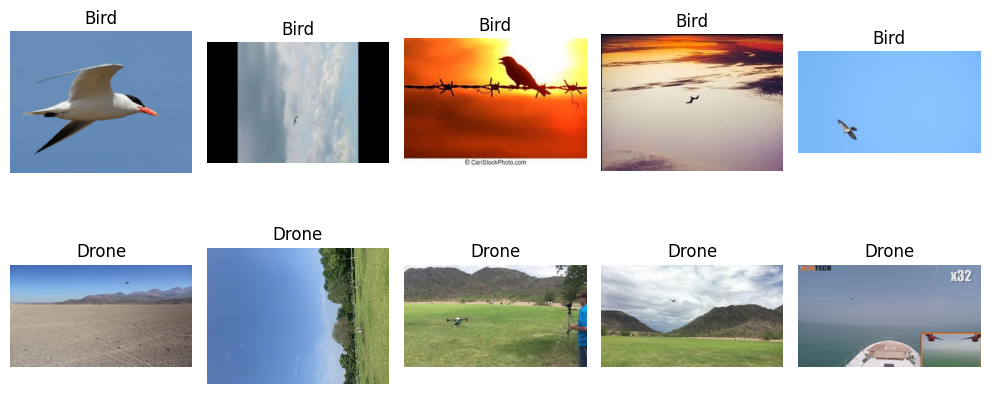

In [29]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_random_images(bird_dir, drone_dir, num_images=3, output_filename="dataset_samples.png"):
    """
    Displays a specified number of random images from bird and drone directories in a single figure,
    with smaller sub-images.

    Args:
        bird_dir: Path to the directory containing bird images.
        drone_dir: Path to the directory containing drone images.
        num_images: Number of images to display from each category.
        output_filename: Name of the file to save the figure.
    """

    def load_and_display(directory, category_name, axes, row_index):
        """Helper function to load and display images from a single directory."""
        image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        random_images = random.sample(image_files, min(num_images, len(image_files)))

        for i, image_file in enumerate(random_images):
            image_path = os.path.join(directory, image_file)
            try:
                img = Image.open(image_path)
                # No need to resize here; matplotlib handles subplot sizing
                axes[row_index, i].imshow(img)
                axes[row_index, i].axis('off')
                axes[row_index, i].set_title(category_name)

            except (FileNotFoundError, OSError, Image.UnidentifiedImageError) as e:
                print(f"Error loading image {image_path}: {e}")
                axes[row_index, i].axis('off')

    # --- Key Change: Adjust figsize for smaller subplots ---
    fig, axes = plt.subplots(2, num_images, figsize=(2 * num_images, 5))  # Smaller figsize

    load_and_display(bird_dir, "Bird", axes, 0)
    load_and_display(drone_dir, "Drone", axes, 1)

    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.show()


# Example usage:
bird_directory = "/kaggle/input/drone-vs-bird/dataset/bird"
drone_directory = "/kaggle/input/drone-vs-bird/dataset/drone"

if not os.path.isdir(bird_directory):
    print(f"Error: Bird directory not found: {bird_directory}")
elif not os.path.isdir(drone_directory):
    print(f"Error: Drone directory not found: {drone_directory}")
else:
    display_random_images(bird_directory, drone_directory, num_images=5, output_filename="bird_drone_combined.png")

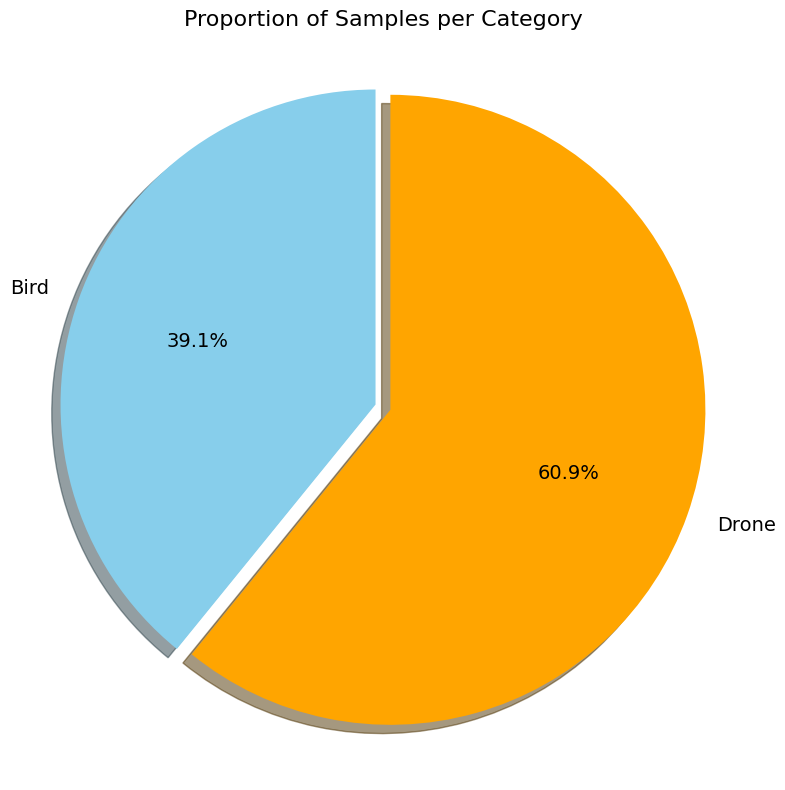

In [45]:
import os
import matplotlib.pyplot as plt

def plot_category_pie_chart(bird_dir, drone_dir, output_filename="category_pie_chart.png"):
    """
    Plots the proportion of samples in each category (bird and drone) using a pie chart.

    Args:
        bird_dir: Path to the directory containing bird images.
        drone_dir: Path to the directory containing drone images.
        output_filename: Name of the file to save the chart.
    """

    # Count the number of files in each directory
    bird_count = len([f for f in os.listdir(bird_dir) if os.path.isfile(os.path.join(bird_dir, f))])
    drone_count = len([f for f in os.listdir(drone_dir) if os.path.isfile(os.path.join(drone_dir, f))])

    # Create the pie chart data
    categories = ['Bird', 'Drone']
    counts = [bird_count, drone_count]
    total_count = sum(counts)
    proportions = [count / total_count for count in counts]  # Calculate proportions

    # Create the pie chart
    plt.figure(figsize=(8, 8))  # Adjust figure size as needed; keep it square for a better pie
    plt.pie(
        proportions,
        labels=categories,
        autopct='%1.1f%%',  # Display percentages with one decimal place
        startangle=90,  # Start the first slice at 90 degrees (aesthetic)
        colors=['skyblue', 'orange'],  # Customize colors
        explode=(0.05, 0),  # "Explode" the first slice (Bird) slightly for emphasis (optional)
        shadow=True,  # Add a shadow for a 3D effect (optional)
        textprops={'fontsize': 14}  # Increase font size for labels and percentages
    )

    plt.title('Proportion of Samples per Category', fontsize=16)  # Increase title font size
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.show()

# Example usage:
bird_directory = "/kaggle/input/drone-vs-bird/dataset/bird"
drone_directory = "/kaggle/input/drone-vs-bird/dataset/drone"

if not os.path.isdir(bird_directory):
    print(f"Error: Bird directory not found: {bird_directory}")
elif not os.path.isdir(drone_directory):
    print(f"Error: Drone directory not found: {drone_directory}")
else:
    plot_category_pie_chart(bird_directory, drone_directory, "bird_drone_pie_chart.png")

In [33]:
import pandas as pd

# File path
file_path = '/kaggle/working/Results/final_results.xlsx'

# Read data from each sheet
df_70 = pd.read_excel(file_path, sheet_name='split-70')
df_80 = pd.read_excel(file_path, sheet_name='split-80')
df_90 = pd.read_excel(file_path, sheet_name='split-90')  # Assuming you meant split-90 instead of split-80 repeated

# Function to get top 10 models from a dataframe
def get_top_models(df, split_name):
    # Sort by Mean Accuracy in descending order and get top 10
    top_10 = df.nlargest(10, 'Mean Accuracy')[['Model', 'Mean Accuracy']]
    return top_10

# Get top 10 models for each split
top_70 = get_top_models(df_70, '70')
top_80 = get_top_models(df_80, '80')
top_90 = get_top_models(df_90, '90')

# Print results
print("Top 10 Models for Split 70:")
print("--------------------------")
for index, row in top_70.iterrows():
    print(f"{index + 1}. {row['Model']}: {row['Mean Accuracy']:.2f}%")
print("\n")

print("Top 10 Models for Split 80:")
print("--------------------------")
for index, row in top_80.iterrows():
    print(f"{index + 1}. {row['Model']}: {row['Mean Accuracy']:.2f}%")
print("\n")

print("Top 10 Models for Split 90:")
print("--------------------------")
for index, row in top_90.iterrows():
    print(f"{index + 1}. {row['Model']}: {row['Mean Accuracy']:.2f}%")

Top 10 Models for Split 70:
--------------------------
36. convnext_base: 99.66%
13. densenet201: 99.45%
17. regnet_y_32gf: 99.45%
15. convnext_large: 99.42%
14. resnext101_32x8d: 99.40%
22. convnext_tiny: 99.35%
26. wide_resnet50_2: 99.35%
24. resnext50_32x4d: 99.33%
38. wide_resnet101_2: 99.32%
16. regnet_x_32gf: 99.30%


Top 10 Models for Split 80:
--------------------------
36. convnext_base: 99.51%
7. densenet169: 99.49%
18. convnext_small: 99.49%
22. convnext_tiny: 99.49%
3. regnet_y_16gf: 99.47%
15. convnext_large: 99.47%
13. densenet201: 99.46%
17. regnet_y_32gf: 99.44%
16. regnet_x_32gf: 99.39%
14. resnext101_32x8d: 99.37%


Top 10 Models for Split 90:
--------------------------
13. densenet201: 99.61%
16. regnet_x_32gf: 99.61%
22. convnext_tiny: 99.61%
15. convnext_large: 99.56%
36. convnext_base: 99.51%
38. wide_resnet101_2: 99.51%
14. resnext101_32x8d: 99.47%
24. resnext50_32x4d: 99.47%
3. regnet_y_16gf: 99.46%
17. regnet_y_32gf: 99.46%


Analyzing Split 70:
Plot saved as: /kaggle/working/split_70_accuracy_vs_time.png


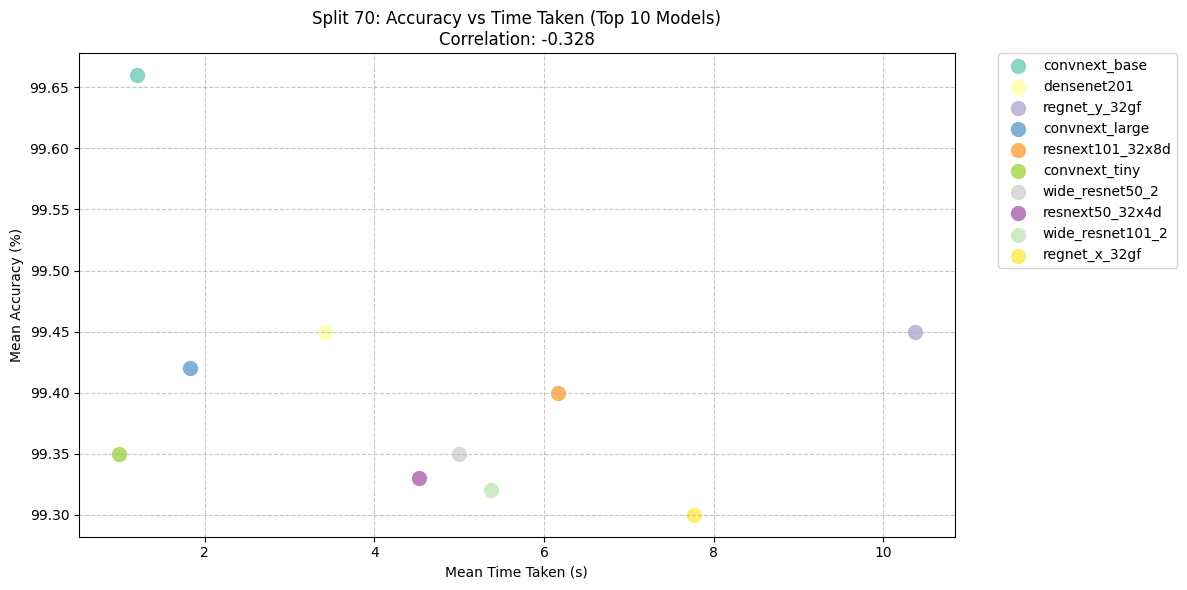


Top 10 Models for Split 70:
---------------------------------
36. convnext_base: Accuracy = 99.66%, Time = 1.20s
13. densenet201: Accuracy = 99.45%, Time = 3.42s
17. regnet_y_32gf: Accuracy = 99.45%, Time = 10.37s
15. convnext_large: Accuracy = 99.42%, Time = 1.83s
14. resnext101_32x8d: Accuracy = 99.40%, Time = 6.17s
22. convnext_tiny: Accuracy = 99.35%, Time = 0.99s
26. wide_resnet50_2: Accuracy = 99.35%, Time = 5.00s
24. resnext50_32x4d: Accuracy = 99.33%, Time = 4.53s
38. wide_resnet101_2: Accuracy = 99.32%, Time = 5.37s
16. regnet_x_32gf: Accuracy = 99.30%, Time = 7.77s

Analyzing Split 80:
Plot saved as: /kaggle/working/split_80_accuracy_vs_time.png


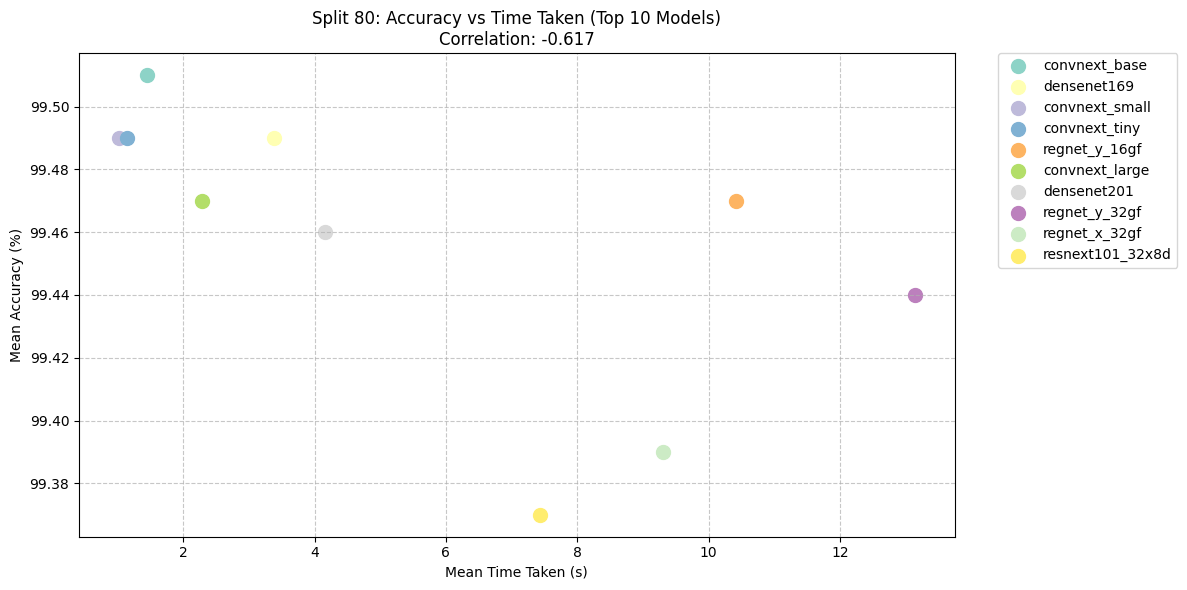


Top 10 Models for Split 80:
---------------------------------
36. convnext_base: Accuracy = 99.51%, Time = 1.45s
7. densenet169: Accuracy = 99.49%, Time = 3.39s
18. convnext_small: Accuracy = 99.49%, Time = 1.02s
22. convnext_tiny: Accuracy = 99.49%, Time = 1.14s
3. regnet_y_16gf: Accuracy = 99.47%, Time = 10.41s
15. convnext_large: Accuracy = 99.47%, Time = 2.28s
13. densenet201: Accuracy = 99.46%, Time = 4.16s
17. regnet_y_32gf: Accuracy = 99.44%, Time = 13.14s
16. regnet_x_32gf: Accuracy = 99.39%, Time = 9.31s
14. resnext101_32x8d: Accuracy = 99.37%, Time = 7.43s

Analyzing Split 90:
Plot saved as: /kaggle/working/split_90_accuracy_vs_time.png


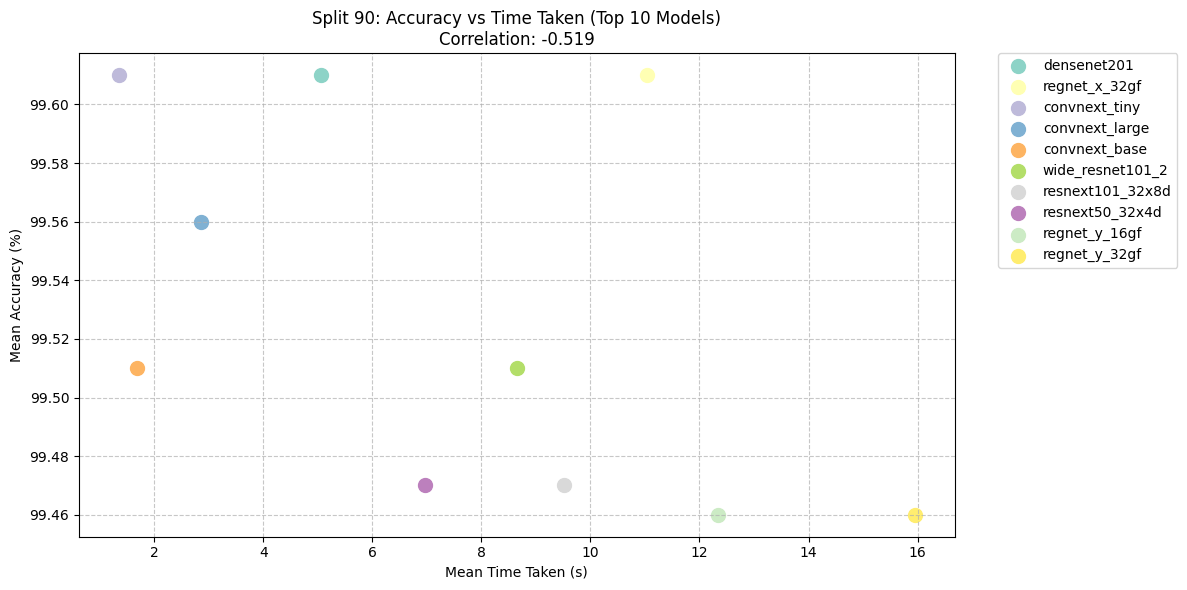


Top 10 Models for Split 90:
---------------------------------
13. densenet201: Accuracy = 99.61%, Time = 5.05s
16. regnet_x_32gf: Accuracy = 99.61%, Time = 11.04s
22. convnext_tiny: Accuracy = 99.61%, Time = 1.35s
15. convnext_large: Accuracy = 99.56%, Time = 2.86s
36. convnext_base: Accuracy = 99.51%, Time = 1.69s
38. wide_resnet101_2: Accuracy = 99.51%, Time = 8.66s
14. resnext101_32x8d: Accuracy = 99.47%, Time = 9.52s
24. resnext50_32x4d: Accuracy = 99.47%, Time = 6.96s
3. regnet_y_16gf: Accuracy = 99.46%, Time = 12.34s
17. regnet_y_32gf: Accuracy = 99.46%, Time = 15.95s


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File path
file_path = '/kaggle/working/Results/final_results.xlsx'

# Read data from each sheet
df_70 = pd.read_excel(file_path, sheet_name='split-70')
df_80 = pd.read_excel(file_path, sheet_name='split-80')
df_90 = pd.read_excel(file_path, sheet_name='split-90')

# Function to get top 10 models, create scatter plot with legend, and save it
def analyze_and_plot(df, split_name):
    # Get top 10 models by accuracy
    top_10 = df.nlargest(10, 'Mean Accuracy')[['Model', 'Mean Accuracy', 'Mean Time Taken (s)']]
    
    # Calculate correlation
    correlation = top_10['Mean Accuracy'].corr(top_10['Mean Time Taken (s)'])
    
    # Create scatter plot
    plt.figure(figsize=(12, 6))
    
    # Generate distinct colors for each model
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_10)))
    
    # Plot each point with a different color
    for i, (index, row) in enumerate(top_10.iterrows()):
        plt.scatter(row['Mean Time Taken (s)'], 
                   row['Mean Accuracy'], 
                   s=100, 
                   color=colors[i], 
                   label=row['Model'])
    
    # Customize plot
    plt.xlabel('Mean Time Taken (s)')
    plt.ylabel('Mean Accuracy (%)')
    plt.title(f'Split {split_name}: Accuracy vs Time Taken (Top 10 Models)\nCorrelation: {correlation:.3f}')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend on the right side
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Save the plot
    output_path = f'/kaggle/working/split_{split_name}_accuracy_vs_time.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {output_path}")
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    # Print top 10 models with accuracy and time
    print(f"\nTop 10 Models for Split {split_name}:")
    print("---------------------------------")
    for index, row in top_10.iterrows():
        print(f"{index + 1}. {row['Model']}: Accuracy = {row['Mean Accuracy']:.2f}%, Time = {row['Mean Time Taken (s)']:.2f}s")
    
    return top_10

# Analyze and plot for each split
print("Analyzing Split 70:")
top_70 = analyze_and_plot(df_70, '70')

print("\nAnalyzing Split 80:")
top_80 = analyze_and_plot(df_80, '80')

print("\nAnalyzing Split 90:")
top_90 = analyze_and_plot(df_90, '90')

Analyzing Performance Consistency Across Splits (Dotted Lines):
Plot saved as: /kaggle/working/performance_consistency_across_splits_dotted.png


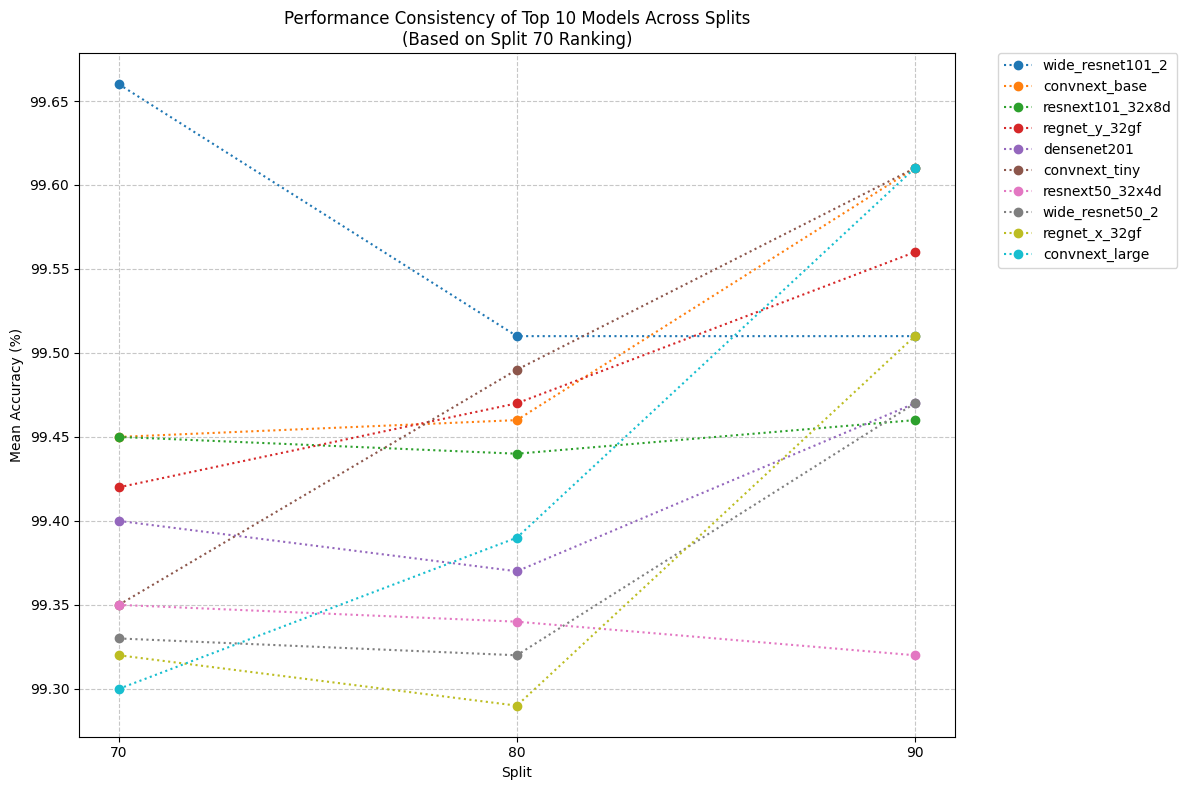


Performance Consistency Data:
-----------------------------
              Model  Split 70  Split 80  Split 90
8  wide_resnet101_2     99.66     99.51     99.51
0     convnext_base     99.45     99.46     99.61
4  resnext101_32x8d     99.45     99.44     99.46
2     regnet_y_32gf     99.42     99.47     99.56
1       densenet201     99.40     99.37     99.47
5     convnext_tiny     99.35     99.49     99.61
7   resnext50_32x4d     99.35     99.34     99.32
6   wide_resnet50_2     99.33     99.32     99.47
9     regnet_x_32gf     99.32     99.29     99.51
3    convnext_large     99.30     99.39     99.61

Top 10 Models from Split 70 and Their Consistency:
------------------------------------------------
wide_resnet101_2:
  Split 70: 99.66%
  Split 80: 99.51%
  Split 90: 99.51%

convnext_base:
  Split 70: 99.45%
  Split 80: 99.46%
  Split 90: 99.61%

resnext101_32x8d:
  Split 70: 99.45%
  Split 80: 99.44%
  Split 90: 99.46%

regnet_y_32gf:
  Split 70: 99.42%
  Split 80: 99.47%
  Split 90

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File path
file_path = '/kaggle/working/Results/final_results.xlsx'

# Read data from each sheet
df_70 = pd.read_excel(file_path, sheet_name='split-70')
df_80 = pd.read_excel(file_path, sheet_name='split-80')
df_90 = pd.read_excel(file_path, sheet_name='split-90')

# Function to analyze and plot performance consistency with dotted lines
def plot_performance_consistency(df_70, df_80, df_90):
    # Get top 10 models from split 70 based on Mean Accuracy
    top_10_models = df_70.nlargest(10, 'Mean Accuracy')['Model'].tolist()
    
    # Create a DataFrame to hold accuracy across splits for these models
    consistency_df = pd.DataFrame({
        'Model': top_10_models,
        'Split 70': df_70[df_70['Model'].isin(top_10_models)]['Mean Accuracy'].values,
        'Split 80': df_80[df_80['Model'].isin(top_10_models)]['Mean Accuracy'].values,
        'Split 90': df_90[df_90['Model'].isin(top_10_models)]['Mean Accuracy'].values
    })
    
    # Sort by Split 70 accuracy for consistent plotting
    consistency_df = consistency_df.sort_values('Split 70', ascending=False)
    
    # Create line plot
    plt.figure(figsize=(12, 8))
    
    # Plot dotted lines for each model
    for index, row in consistency_df.iterrows():
        plt.plot(['70', '80', '90'], 
                [row['Split 70'], row['Split 80'], row['Split 90']], 
                marker='o', 
                linestyle=':',  # Changed to dotted line
                label=row['Model'])
    
    # Customize plot
    plt.xlabel('Split')
    plt.ylabel('Mean Accuracy (%)')
    plt.title('Performance Consistency of Top 10 Models Across Splits\n(Based on Split 70 Ranking)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Save the plot
    output_path = '/kaggle/working/performance_consistency_across_splits_dotted.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {output_path}")
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    # Print the data
    print("\nPerformance Consistency Data:")
    print("-----------------------------")
    print(consistency_df.round(2))
    print("\nTop 10 Models from Split 70 and Their Consistency:")
    print("------------------------------------------------")
    for index, row in consistency_df.iterrows():
        print(f"{row['Model']}:")
        print(f"  Split 70: {row['Split 70']:.2f}%")
        print(f"  Split 80: {row['Split 80']:.2f}%")
        print(f"  Split 90: {row['Split 90']:.2f}%")
        print()

# Run the analysis
print("Analyzing Performance Consistency Across Splits (Dotted Lines):")
plot_performance_consistency(df_70, df_80, df_90)

Analyzing Time Efficiency for Split 70:
Plot saved as: /kaggle/working/time_efficiency_split_70.png


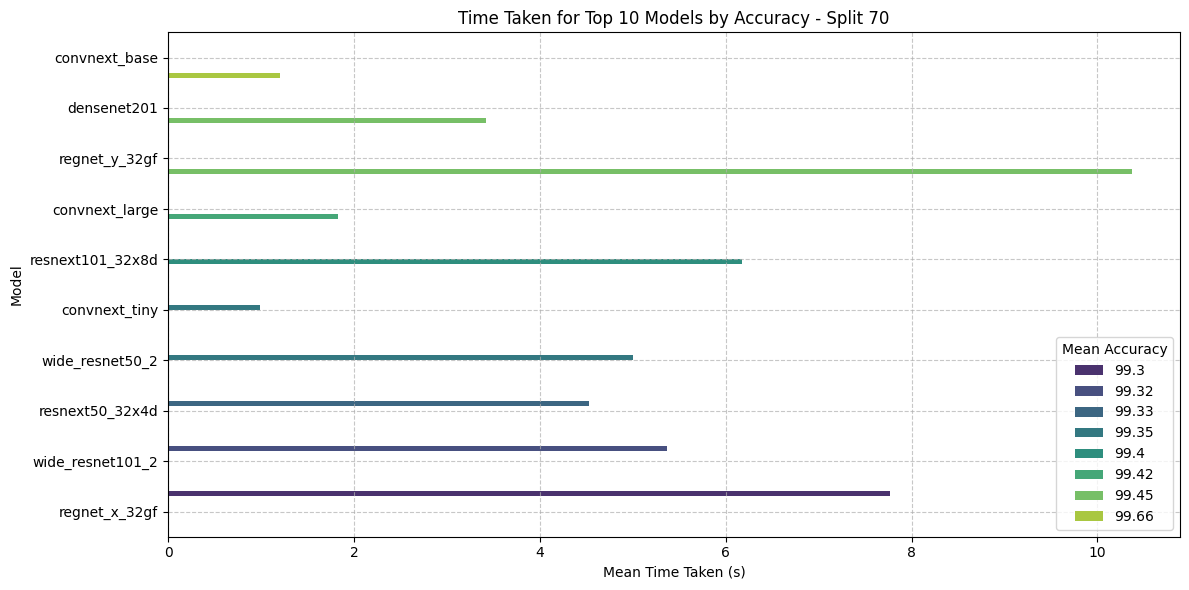


Time Efficiency for Top 10 Models - Split 70:
-------------------------------------------------
convnext_base:
  Accuracy: 99.66%
  Time Taken: 1.20s

densenet201:
  Accuracy: 99.45%
  Time Taken: 3.42s

regnet_y_32gf:
  Accuracy: 99.45%
  Time Taken: 10.37s

convnext_large:
  Accuracy: 99.42%
  Time Taken: 1.83s

resnext101_32x8d:
  Accuracy: 99.40%
  Time Taken: 6.17s

convnext_tiny:
  Accuracy: 99.35%
  Time Taken: 0.99s

wide_resnet50_2:
  Accuracy: 99.35%
  Time Taken: 5.00s

resnext50_32x4d:
  Accuracy: 99.33%
  Time Taken: 4.53s

wide_resnet101_2:
  Accuracy: 99.32%
  Time Taken: 5.37s

regnet_x_32gf:
  Accuracy: 99.30%
  Time Taken: 7.77s


Analyzing Time Efficiency for Split 80:
Plot saved as: /kaggle/working/time_efficiency_split_80.png


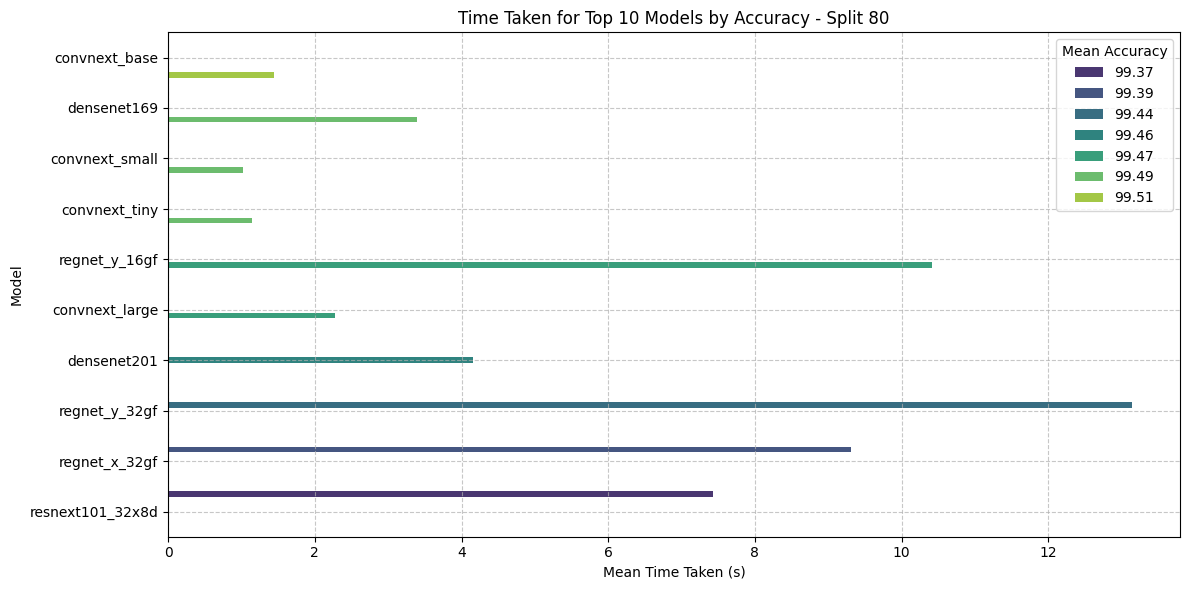


Time Efficiency for Top 10 Models - Split 80:
-------------------------------------------------
convnext_base:
  Accuracy: 99.51%
  Time Taken: 1.45s

densenet169:
  Accuracy: 99.49%
  Time Taken: 3.39s

convnext_small:
  Accuracy: 99.49%
  Time Taken: 1.02s

convnext_tiny:
  Accuracy: 99.49%
  Time Taken: 1.14s

regnet_y_16gf:
  Accuracy: 99.47%
  Time Taken: 10.41s

convnext_large:
  Accuracy: 99.47%
  Time Taken: 2.28s

densenet201:
  Accuracy: 99.46%
  Time Taken: 4.16s

regnet_y_32gf:
  Accuracy: 99.44%
  Time Taken: 13.14s

regnet_x_32gf:
  Accuracy: 99.39%
  Time Taken: 9.31s

resnext101_32x8d:
  Accuracy: 99.37%
  Time Taken: 7.43s


Analyzing Time Efficiency for Split 90:
Plot saved as: /kaggle/working/time_efficiency_split_90.png


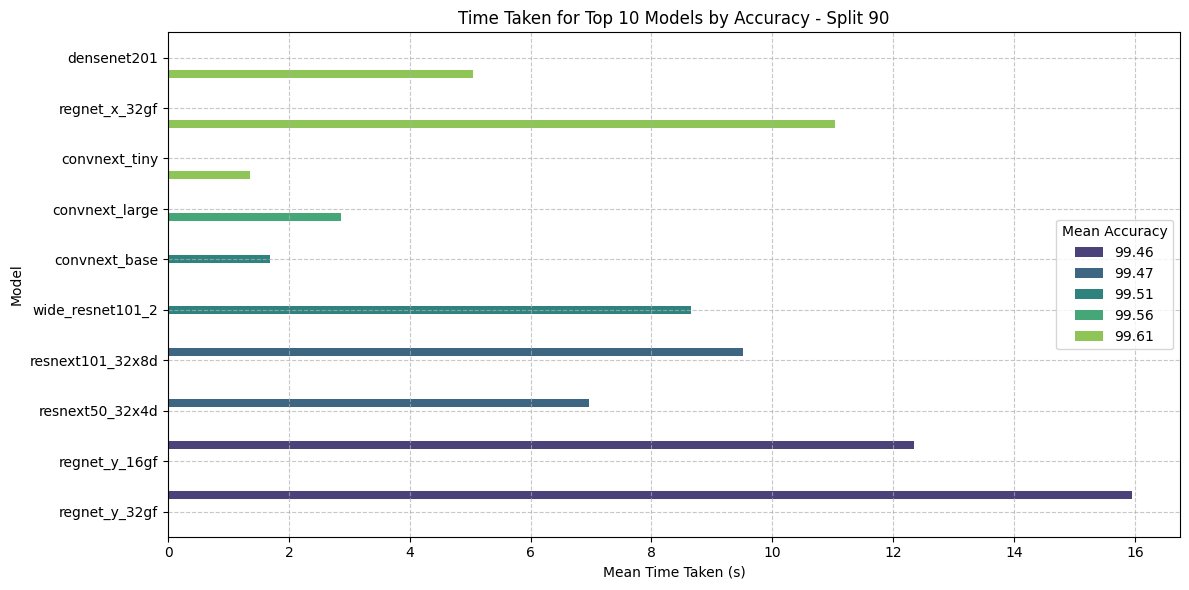


Time Efficiency for Top 10 Models - Split 90:
-------------------------------------------------
densenet201:
  Accuracy: 99.61%
  Time Taken: 5.05s

regnet_x_32gf:
  Accuracy: 99.61%
  Time Taken: 11.04s

convnext_tiny:
  Accuracy: 99.61%
  Time Taken: 1.35s

convnext_large:
  Accuracy: 99.56%
  Time Taken: 2.86s

convnext_base:
  Accuracy: 99.51%
  Time Taken: 1.69s

wide_resnet101_2:
  Accuracy: 99.51%
  Time Taken: 8.66s

resnext101_32x8d:
  Accuracy: 99.47%
  Time Taken: 9.52s

resnext50_32x4d:
  Accuracy: 99.47%
  Time Taken: 6.96s

regnet_y_16gf:
  Accuracy: 99.46%
  Time Taken: 12.34s

regnet_y_32gf:
  Accuracy: 99.46%
  Time Taken: 15.95s



In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = '/kaggle/working/Results/final_results.xlsx'

# Read data from each sheet
df_70 = pd.read_excel(file_path, sheet_name='split-70')
df_80 = pd.read_excel(file_path, sheet_name='split-80')
df_90 = pd.read_excel(file_path, sheet_name='split-90')

# Function to perform time efficiency analysis (bar plot only)
def time_efficiency_analysis(df, split_name):
    # Extract time and accuracy
    top_10 = df.nlargest(10, 'Mean Accuracy')[['Model', 'Mean Accuracy', 'Mean Time Taken (s)']]
    
    # Create figure with single subplot (bar plot only)
    plt.figure(figsize=(12, 6))
    
    # Plot: Bar plot of time taken for top 10 models by accuracy
    sns.barplot(x='Mean Time Taken (s)', y='Model', hue='Mean Accuracy', 
                data=top_10, palette='viridis')
    plt.title(f'Time Taken for Top 10 Models by Accuracy - Split {split_name}')
    plt.xlabel('Mean Time Taken (s)')
    plt.ylabel('Model')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and save
    plt.tight_layout()
    output_path = f'/kaggle/working/time_efficiency_split_{split_name}.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {output_path}")
    
    # Show plot
    plt.show()
    
    # Print detailed data
    print(f"\nTime Efficiency for Top 10 Models - Split {split_name}:")
    print("-------------------------------------------------")
    for index, row in top_10.iterrows():
        print(f"{row['Model']}:")
        print(f"  Accuracy: {row['Mean Accuracy']:.2f}%")
        print(f"  Time Taken: {row['Mean Time Taken (s)']:.2f}s")
        print()

# Run the analysis for each split
print("Analyzing Time Efficiency for Split 70:")
time_efficiency_analysis(df_70, '70')

print("\nAnalyzing Time Efficiency for Split 80:")
time_efficiency_analysis(df_80, '80')

print("\nAnalyzing Time Efficiency for Split 90:")
time_efficiency_analysis(df_90, '90')

Analyzing Standard Deviation Comparison:
Heatmap saved as: /kaggle/working/std_comparison_heatmap.png


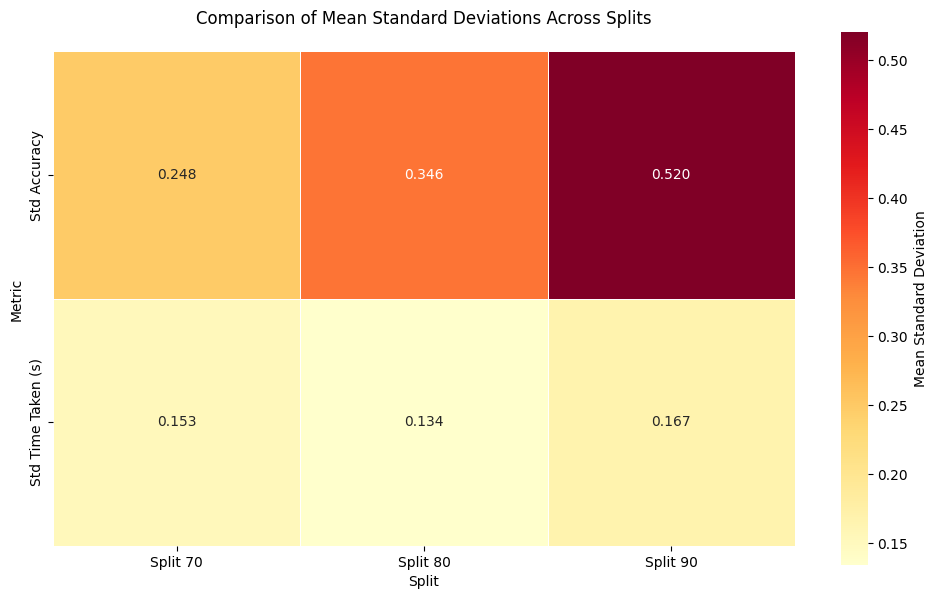


Mean Standard Deviations Across Splits:
---------------------------------------
                    Split 70  Split 80  Split 90
Std Accuracy           0.248     0.346     0.520
Std Time Taken (s)     0.153     0.134     0.167

Top 10 Models by Accuracy for Split 70:
------------------------------------------------
convnext_base:
  Accuracy: 99.66% ± 0.150
  Time Taken: 1.20s ± 0.060

densenet201:
  Accuracy: 99.45% ± 0.100
  Time Taken: 3.42s ± 0.150

regnet_y_32gf:
  Accuracy: 99.45% ± 0.120
  Time Taken: 10.37s ± 0.150

convnext_large:
  Accuracy: 99.42% ± 0.220
  Time Taken: 1.83s ± 0.110

resnext101_32x8d:
  Accuracy: 99.40% ± 0.120
  Time Taken: 6.17s ± 0.070

convnext_tiny:
  Accuracy: 99.35% ± 0.160
  Time Taken: 0.99s ± 0.030

wide_resnet50_2:
  Accuracy: 99.35% ± 0.320
  Time Taken: 5.00s ± 0.150

resnext50_32x4d:
  Accuracy: 99.33% ± 0.230
  Time Taken: 4.53s ± 0.080

wide_resnet101_2:
  Accuracy: 99.32% ± 0.090
  Time Taken: 5.37s ± 0.140

regnet_x_32gf:
  Accuracy: 99.30%

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# File path
file_path = '/kaggle/working/Results/final_results.xlsx'

# Read data from each sheet
df_70 = pd.read_excel(file_path, sheet_name='split-70')
df_80 = pd.read_excel(file_path, sheet_name='split-80')
df_90 = pd.read_excel(file_path, sheet_name='split-90')

# Function to create heatmap of standard deviations
def plot_std_heatmap(df_70, df_80, df_90):
    # Select standard deviation columns
    std_columns = ['Std Accuracy', 'Std Time Taken (s)']
    
    # Use explicit Std columns since they exist in the data
    std_data = {
        'Split 70': [df_70['Std Accuracy'].mean(), df_70['Std Time Taken (s)'].mean()],
        'Split 80': [df_80['Std Accuracy'].mean(), df_80['Std Time Taken (s)'].mean()],
        'Split 90': [df_90['Std Accuracy'].mean(), df_90['Std Time Taken (s)'].mean()]
    }
    
    # Create DataFrame for heatmap
    std_df = pd.DataFrame(std_data, index=['Std Accuracy', 'Std Time Taken (s)'])
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(std_df, 
                annot=True,  # Show values in cells
                cmap='YlOrRd',  # Yellow-Orange-Red colormap
                fmt='.3f',  # Format to 3 decimal places
                cbar_kws={'label': 'Mean Standard Deviation'},  # Colorbar label
                linewidths=0.5,  # Line width between cells
                square=True)  # Make cells square
    
    # Customize plot
    plt.title('Comparison of Mean Standard Deviations Across Splits', pad=20)
    plt.xlabel('Split')
    plt.ylabel('Metric')
    
    # Save the plot
    output_path = '/kaggle/working/std_comparison_heatmap.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"Heatmap saved as: {output_path}")
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    # Print the data
    print("\nMean Standard Deviations Across Splits:")
    print("---------------------------------------")
    print(std_df.round(3))
    
    # Additional analysis: Top 10 models by accuracy with their stds
    for split_name, df in [('70', df_70), ('80', df_80), ('90', df_90)]:
        # Use the mean columns for top 10 selection
        top_10 = df.nlargest(10, 'Mean Accuracy')[['Model', 'Mean Accuracy', 'Mean Time Taken (s)', 
                                                  'Std Accuracy', 'Std Time Taken (s)']]
        
        print(f"\nTop 10 Models by Accuracy for Split {split_name}:")
        print("------------------------------------------------")
        for index, row in top_10.iterrows():
            print(f"{row['Model']}:")
            print(f"  Accuracy: {row['Mean Accuracy']:.2f}% ± {row['Std Accuracy']:.3f}")
            print(f"  Time Taken: {row['Mean Time Taken (s)']:.2f}s ± {row['Std Time Taken (s)']:.3f}")
            print()

# Run the analysis
print("Analyzing Standard Deviation Comparison:")
plot_std_heatmap(df_70, df_80, df_90)